<a href="https://colab.research.google.com/github/suridian/Applied-Deep-Learning/blob/main/UTS_Paper1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing

In [1]:
def installing_requirements():
  !pip install rasterio
  !pip install kaggle

#Requirements

In [4]:
# A
import argparse
# C
import cv2
# G
import glob
# H
import h5py
# I
import imgaug as ia
import importlib.util
# J
import json
# M
import math 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# N
import numpy as np
# O
import os
# P
import pandas as pd
# R
import random
import rasterio
# S
import scipy.misc
import shutil
import signal
import sys
# T
import tensorflow
import time
# W
import webbrowser

### Keras
from keras.layers import  * 
from keras.models import Model, Sequential, load_model as keras_load_model
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, TensorBoard, EarlyStopping
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import losses
from keras.optimizers import *
from keras.utils.generic_utils import get_custom_objects
### Tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
### Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
### Random
from random import randint
from random import shuffle
### ImgAug
from imgaug import augmenters as iaa
from imgaug import parameters as iap
### Others
from __future__ import division
from IPython.display import clear_output
from PIL import Image
from skimage.transform import resize
from skimage import data

#Load Data

###Load Data Tests and Labels

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d suridianprtma/images-labels-bone

 93% 170M/183M [00:02<00:00, 63.9MB/s]
100% 183M/183M [00:02<00:00, 74.2MB/s]


In [ ]:
!unzip images-labels-bone

In [ ]:
os.mkdir('bone-labels')
os.mkdir('bone-tests')

In [ ]:
for x in range(4200,4560):
  if os.path.isfile(f"/content/good_images_bone/good image bone_edited/{x}.png"):
    shutil.move(f"/content/good_images_bone/good image bone_edited/{x}.png", "/content/bone-tests")

In [ ]:
!rm -rf good_images_bone

In [ ]:
for x in range(4200,4560):
  if os.path.isfile(f"/content/good_labels_bone/label_good image/{x}_label.png"):
    shutil.move(f"/content/good_labels_bone/label_good image/{x}_label.png", "/content/bone-labels")

In [ ]:
!rm -rf good_labels_bone
!rm -rf images-labels-bone.zip

#RGB to Label

###Function Get Mask from Color

In [ ]:
def get_mask_from_color( image, color ):
    """ Given one image and one color, returns a mask of the same shape as the image, with True values on the pixel positions with the same specified color"""
    rows, columns, channels = image.shape
    total_pixels = rows * columns
    image_flat = image.reshape(total_pixels, channels)
    color_array = np.array([color,] * total_pixels)
    channels_mask = np.isclose(image_flat, color_array, atol = 100)
    #combine channels
    mask = np.logical_and(channels_mask[:,0], channels_mask[:,1])
    mask = np.logical_and(mask, channels_mask[:,2])
    return mask.reshape(rows,columns)

###*Function* Get 012 Label

In [ ]:
def get_012_label(image, n_colors = 3, colors = [[255,255,255], [255,255,0], [0,0,255]]):
    """ Given one image, returns labeling 0,1,2 for 3 colours."""
    #color_0 = [255,255,255]
    #color_1 = [255,255,0]
    #color_2 = [0,0,255]
    
    label_012 = np.zeros((image.shape[0], image.shape[1]))
    if(n_colors == 2):
        mask = get_mask_from_color(image, colors[2])
        label_012[mask] = 1
    elif(n_colors == 3):
        mask = get_mask_from_color(image, colors[1])
        label_012[mask] = 1
        mask = get_mask_from_color(image, colors[2])
        label_012[mask] = 2
    else:
        print("number of colors not implemented")
        return False

    return label_012

###Function Get Categorical Label

In [ ]:
def get_categorical_label(image, n_classes = 3):
    """ Given an image, computes the 012 label and uses keras to compute the categorical label"""
    label_012 = get_012_label(image, n_classes)
    return to_categorical(label_012, n_classes)

#Setting Dataset

In [ ]:
main_path = "/content"
data_to_add = ['hand']
image_size = 200
train_size = 0.3
n_classes = 3
classes = 3

EXAMPLES_PER_CATEGORY = 0

In [ ]:
chosen_one_per_class = 0
bodypart_choice = []
one_per_class = []
test_extra = []
extra_need = 0

#Utility

###Function Balanced Test Val Split

In [ ]:
def path_data_labels(main_path, code):
  data_path = []
  labels_path = []
  directory = ["bone-tests", "bone-labels"]
  if code == 0:
    data_path = os.path.join( main_path , directory[0])
    labels_path = os.path.join(main_path, directory[1])
  else:
    data_path = os.path.join( main_path , directory[1])
    labels_path = os.path.join(main_path, directory[0])
  data_path += os.sep + '*.png'
  labels_path += os.sep + '*.png'

  images = glob.glob(data_path)
  images = sorted(images)
  labels =  glob.glob(labels_path)
  labels = sorted(labels)
  return images, labels

In [ ]:
def filename_label_len(main_path, length, img_filename, label_filename, kode):
  directory = ["bone-tests", "bone-labels"]
  images_found = []
  labels_found = []
  if kode == 0:
    for i in range(length):
      images_found.append(  os.path.join(main_path , directory[0]) + os.sep + img_filename[i] + '.png')
      labels_found.append(  os.path.join(main_path , directory[1]) + os.sep + label_filename[i] + '.png')
  else:
    for i in range(length):
      images_found.append(  os.path.join(main_path , directory[1]) + os.sep + img_filename[i] + '.png')
      labels_found.append(  os.path.join(main_path , directory[0]) + os.sep + label_filename[i] + '.png')
  return images_found, labels_found

In [ ]:
def balanced_test_val_split(main_path, data_to_add, image_size, train_size, n_classes, kode):
  images_found = []
  labels_found = []
  images, labels = path_data_labels(main_path, kode)

  # Check that they have the same names
  img_filename = []
  label_filename = []

  for (i, img) in enumerate(images):
    label_filename.append(labels[i].split(os.sep)[-1].split('.')[0])
    img_filename.append(img.split(os.sep)[-1].split('.')[0]  )   

  label_filename = sorted(label_filename)
  img_filename = sorted(img_filename)

  images_found, labels_found = filename_label_len(main_path, len(label_filename), img_filename, label_filename, kode)

  # Read and save all images + labels + bodypart
  images_read = np.zeros((len(images),image_size,image_size,1),dtype=np.float32)
  labels_read = np.zeros((len(labels), image_size, image_size,3),dtype=np.float32)
  bodyparts = np.empty((len(images)),'S10')
  split_names = np.empty((len(images)),'S50')
  for i in range(len(images)):
    filename = images[i]
    img = rasterio.open(filename)
    img = img.read(1)
    images_read[i,...,0] = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
    labels_read[i,...,0] = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)

    label_filename = labels[i]
    labels_images = cv2.imread(label_filename)

    image = data.camera()
    labels_read[i,...] = resize(labels_images, (image_size, image_size))
    labels_read[i,...] = np.uint8(labels_read[i,...])
    labels_read[i,...] = 255*get_categorical_label(labels_read[i,...], n_classes)

    # Clean bodyparts names
    bodypart = filename.split(os.sep)[-1].split('_')[0].lower()
    split_names[i] = filename.split(os.sep)[-1].split('.')[0].lower()             
    # Remove numbers
    bodypart = ''.join(i for i in bodypart if not i.isdigit())
    bodypart = bodypart.split('.')[0]
    bodypart = bodypart.encode("ascii", "ignore")
    bodyparts[i] = bodypart
  unique, counts = np.unique(bodyparts, return_counts=True)
  unique_per_category = dict(zip(unique, counts))

  indices = np.arange(images_read.shape[0])
  # Build balanced test and validation sets
  for i in unique_per_category:
    split_category = np.where(bodyparts==i)[0].tolist()
    #pick one from each category to be part of the test set
    chosen_one_per_class = random.choice(split_category)
    indices_to_remove = np.argwhere( indices ==chosen_one_per_class)[0].tolist()
    indices = np.delete(indices, indices_to_remove)
    one_per_class.append(chosen_one_per_class)
  
  bodyparts_cut = bodyparts[indices]
  unique, counts = np.unique(bodyparts_cut, return_counts=True)
  unique_per_category = dict(zip(unique, counts))

  extra_need = 34
  guard_of_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49]
  guardian = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]]
  counter = 0
  counter_lv2 = 0
  counter_lv3 = 0
  while ( counter < extra_need ):
    #reshuffle dictionary
    keys = list(unique_per_category.keys())
    # np.random.shuffle(keys)
    for bodypart in keys:
      if ( counter >= extra_need):
        break
      if( unique_per_category[bodypart] == 1 or unique_per_category[bodypart] == 0):
        continue

      #get random sample of that bodypart
      bodypart_indices = np.where(bodyparts[indices] == bodypart)[0].tolist()
      # bodypart_choice = indices[bodypart_indices]
      bodypart_choice.append(random.choice(indices[bodypart_indices]))
      if counter_lv3 == 49:
        counter_lv3 = 0
      test_extra.append(guard_of_indices[counter])
      #remove bodypart index to avoid repetition
      unique_per_category[bodypart] -= 1
      if counter_lv2 == 12:
        counter_lv2 = 0
      remove_bodypart_index = np.argwhere( indices == bodypart_choice[counter])[0].tolist()
      indices = np.delete(indices, guardian[counter_lv2])
      counter += 1
      counter_lv2 += 1
		 
  test_indices = np.concatenate((one_per_class,test_extra))

  images_train = images_read[indices,...]
  body_train = bodyparts[indices]
  split_names_train = split_names[indices]
  labels_train = labels_read[indices,...]

  images_test = images_read[test_indices[:int(len(test_indices)/2)],...]
  body_test = bodyparts[test_indices[:int(len(test_indices)/2)]]
  split_names_test = split_names[test_indices[:int(len(test_indices)/2)]]
  labels_test = labels_read[test_indices[:int(len(test_indices)/2)],...]

  images_val = images_read[test_indices[int(len(test_indices)/2):],...]
  body_val = bodyparts[test_indices[int(len(test_indices)/2):]]
  split_names_val = split_names[test_indices[int(len(test_indices)/2):]]
  labels_val = labels_read[test_indices[int(len(test_indices)/2):],...]

	# Check that we didn't lose images on the way
  assert (images_train.shape[0] + images_test.shape[0] + images_val.shape[0]) == len(images)

  return images_train, labels_train, body_train, split_names_train, images_test, labels_test, body_test,\
  split_names_test, images_val, labels_val, body_val, split_names_val 

###Shuffle Together Simple

In [ ]:
def shuffle_together_simple(images, labels, bodyparts):

    c = list(zip(images,labels, bodyparts))
    shuffle(c)
    images, labels, bodyparts = zip(*c)    
    images = np.asarray(images)
    labels = np.asarray(labels)
    bodyparts = np.asarray(bodyparts)
    
    return images, labels, bodyparts

###Function Shuffle Together

In [ ]:
def shuffle_together(images, labels, bodyparts, filenames):

    c = list(zip(images,labels, bodyparts,filenames))
    shuffle(c)
    images, labels, bodyparts, filenames = zip(*c)    
    images = np.asarray(images)
    labels = np.asarray(labels)
    bodyparts = np.asarray(bodyparts)
    filenames = np.asarray(filenames)
    
    return images, labels, bodyparts, filenames

###Function Random Crop

In [ ]:
def random_crop(x, y, permin, permax):
    h, w, _ = x.shape
    per_h = random.uniform(permin, permax)
    per_w = random.uniform(permin, permax)
    crop_size = (int((1-per_h)*h),int((1-per_w)*w))

    rangew = (w - crop_size[0]) // 2 if w>crop_size[0] else 0
    rangeh = (h - crop_size[1]) // 2 if h>crop_size[1] else 0
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    # cropped_x = x[offseth:offseth+crop_size[0], offsetw:offsetw+crop_size[1], :]
    # cropped_y = y[offseth:offseth+crop_size[0], offsetw:offsetw+crop_size[1], :]
    cropped_x = x[offseth:offseth+crop_size[0], :]
    cropped_y = y[offseth:offseth+crop_size[0], :]
    resize_x = cv2.resize(cropped_x, (h, w), interpolation=cv2.INTER_CUBIC)
    resize_y = cv2.resize(cropped_y, (h, w), interpolation=cv2.INTER_NEAREST)
    if cropped_y.shape[-1] == 0:
        return x, y
    else:
        return np.reshape(resize_x,(h,w,1)), resize_y

#Create h5 File

In [ ]:
def write_h5(hdf5_name,images_train,labels_train,body_train, file_train, images_test,labels_test,body_test ,\
        file_test,images_val,labels_val,body_val,file_val):

  hdf5_file = h5py.File(hdf5_name, mode='w')
  # Attributes
  hdf5_file.attrs['image_size'] = images_train.shape[2] 
  hdf5_file.attrs['max_value'] = 1.
  hdf5_file.attrs['min_value'] = 0.
  print(body_train.shape)
  # Datasets
  hdf5_file.create_dataset("train_img", images_train.shape, np.float64)
  hdf5_file.create_dataset("train_label", labels_train.shape, np.int)
  hdf5_file.create_dataset("train_bodypart", body_train.shape, 'S10')
  hdf5_file.create_dataset("train_file", file_train.shape, 'S60')

  hdf5_file.create_dataset("test_img", images_test.shape, np.float64)
  hdf5_file.create_dataset("test_label", labels_test.shape, np.int)
  hdf5_file.create_dataset("test_bodypart", body_test.shape, 'S10')
  hdf5_file.create_dataset("test_file", file_test.shape, 'S60')

  hdf5_file.create_dataset("val_img", images_val.shape, np.float64)
  hdf5_file.create_dataset("val_label", labels_val.shape, np.int)
  hdf5_file.create_dataset("val_bodypart", body_val.shape, 'S10')
  hdf5_file.create_dataset("val_file", file_val.shape, 'S60')

  categories = ['train','test','val']
  images_split = [images_train, images_test, images_val]
  labels_split =  [labels_train, labels_test, labels_val]
  bodys_split = [body_train, body_test, body_val]
  names_split = [file_train, file_test, file_val]
  for j  in range(len(images_split)):
    for i in range(images_split[j].shape[0]):
      clear_output(wait=True)
      # Zero mean
      img = images_split[j][i,...] - np.mean(images_split[j][i,...])
      # Normalization -> perform after augmentation
      img = (img-np.min(img))/(np.max(img) - np.min(img)) 
      hdf5_file[categories[j] + '_img'][i, ...] = img
      # same for labels  
      hdf5_file[categories[j] + "_label"][i, ...] = labels_split[j][i,...] 
      hdf5_file[categories[j] + "_bodypart"][i] = bodys_split[j][i]
      hdf5_file[categories[j] + "_file"][i] = names_split[j][i]
            
  hdf5_file.close() 

#Setting Dataset

###Generate File h5

In [ ]:
# output hdf5 file
hdf5_name_tests = 'dataset-tests' 
hdf5_name_labels = 'dataset-labels' 

if(EXAMPLES_PER_CATEGORY == 0):
    hdf5_name_tests = hdf5_name_tests + '_s' + str(image_size) + '.hdf5'
    hdf5_name_labels = hdf5_name_labels + '_s' + str(image_size) + '.hdf5'
else:
    hdf5_name_tests =  hdf5_name_tests +'_s'+str(image_size)+'_a'+ str(EXAMPLES_PER_CATEGORY)+ '.hdf5'
    hdf5_name_labels =  hdf5_name_labels +'_s'+str(image_size)+'_a'+ str(EXAMPLES_PER_CATEGORY)+ '.hdf5'

hdf5_path = "./content"

In [ ]:
chosen_one_per_class = 0
bodypart_choice = []
one_per_class = []
test_extra = []
extra_need = 0

In [ ]:
# Get balanced body parts split into train test and validation sets
images_train, labels_train, body_train, filenames_train, images_test, labels_test, body_test, \
filenames_test, images_val, labels_val, body_val, filenames_val = \
balanced_test_val_split(main_path, data_to_add, image_size, train_size, n_classes,0)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
write_h5(hdf5_name_tests, images_train, labels_train/255, body_train,filenames_train, \
                   images_test, labels_test/255,body_test,filenames_test,\
images_val, labels_val/255,body_val ,filenames_val)

(10,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

In [ ]:
chosen_one_per_class = 0
bodypart_choice = []
one_per_class = []
test_extra = []
extra_need = 0

In [ ]:
# Get balanced data label
images_train, labels_train, body_train, filenames_train, images_test, labels_test, body_test, \
filenames_test, images_val, labels_val, body_val, filenames_val = \
balanced_test_val_split(main_path, data_to_add, image_size, train_size, n_classes,1)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
# Save hdf5 file without augmentations
write_h5(hdf5_name_labels, images_train, labels_train/255, body_train,filenames_train, \
                   images_test, labels_test/255,body_test,filenames_test,\
images_val, labels_val/255,body_val ,filenames_val)

(10,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

###Load h5 File

In [ ]:
hdf5_path = './dataset-tests_s200.hdf5'
dataset = h5py.File(hdf5_path , 'r')

test_images = dataset['test_img'][:]
no_images, height, width, channels = test_images.shape

test_labels = dataset['test_label'][:]

dataset.close()

In [ ]:
hdf5_path = './dataset-labels_s200.hdf5'
dataset_labels = h5py.File(hdf5_path , 'r')

labels_images = dataset_labels['test_img'][:]
no_images, height, width, channels = labels_images.shape

dataset.close()

#Testing Sample

In [ ]:
def testing_sample(test_images):
    fig, axs = plt.subplots(2, 5, figsize=(18, 8))
    axs[0,0].imshow(test_images[5].reshape(200,200), cmap='gray')
    axs[1,0].imshow(labels_images[5].reshape(200,200))
    
    axs[0,1].imshow(test_images[1].reshape(200,200), cmap='gray')
    axs[1,1].imshow(labels_images[1].reshape(200,200))
    
    axs[0,2].imshow(test_images[2].reshape(200,200), cmap='gray')
    axs[1,2].imshow(labels_images[2].reshape(200,200))
    
    axs[0,3].imshow(test_images[3].reshape(200,200), cmap='gray')
    axs[1,3].imshow(labels_images[3].reshape(200,200))
    
    axs[0,4].imshow(test_images[4].reshape(200,200), cmap='gray')
    axs[1,4].imshow(labels_images[4].reshape(200,200))
    
    plt.show()

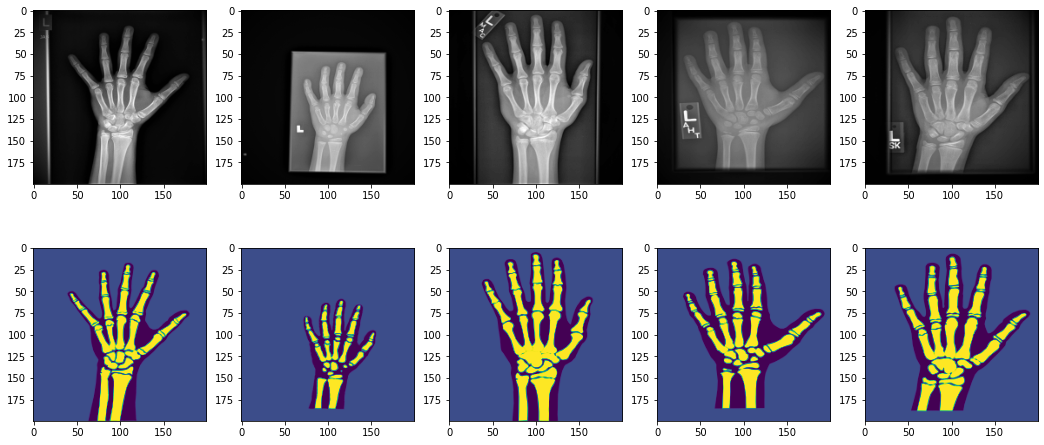

In [ ]:
testing_sample(test_images)

In [ ]:
!pip install import-ipynb
import import_ipynb

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
module = drive.CreateFile({'id':'1_bGw2qVLG_kRh4pzzceRdVHy82ANnk0C'})
module.GetContentFile('XNet.py')

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=48e1e2b0f5a81ff8096a20b8a38e2477fd6d581db807fe69db917181c36b0e79
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


#Generate Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
params_name = '/content/parameters.txt'
save_folder = '/content/gdrive/My Drive/XNet-CNN-XRay-SmallDataset/'

model = '/content/XNet.py'
name = "DLs200_64"

lrate = 0.0001
reg = 0
batch_size = 5
kernel_size = 5
filter_list =  [64,128,256, 512, 1024]
#loss = "fancy"
loss = "categorical_crossentropy"
#loss = "jaccard"
#data = "Humans_CT_Phantom_s224.hdf5"
data_tests = './dataset-labels_s200.hdf5'
data_labels = './dataset-tests_s200.hdf5'
no_epochs = 5000
duplicate = True

In [ ]:
d = {"name":name,
     "model_path": model,
     "data_tests_path": data_tests,
     "data_labels_path": data_labels,
     "save_folder": save_folder,
     "kernel_size": kernel_size,
     "batch_size": batch_size,
     "filters": filter_list,
     "lrate": lrate,
     "reg":reg,
     "loss": loss,
     "no_epochs": no_epochs,
     "duplicate": duplicate}

In [ ]:
if (os.path.isfile(params_name)):
    confirm_metada = input("Warning params file exists, continue? (y/n) ")
    if(confirm_metada == "y"):
        os.remove(params_name)
    else:
        sys.exit()
        
with open(params_name, 'w') as fp:
    json.dump(d, fp)

#Model Trial

In [ ]:
def model_trial(input_shape=(64,64,3), classes=3, kernel_size = 3, filter_depth = (64,128,256,512,0)):
    
    img_input = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(img_input)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation("relu")(batch1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    #100x100
    
    conv2 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(pool1)
    batch2 = BatchNormalization()(conv2)
    act2 = Activation("relu")(batch2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    #50x50
    
    conv3 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool2)
    batch3 = BatchNormalization()(conv3)
    act3 = Activation("relu")(batch3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    #25x25
    
    #Flat
    conv4 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool3)
    batch4 = BatchNormalization()(conv4)
    act4 = Activation("relu")(batch4)
    #25x25
    
    conv5 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act4)
    batch5 = BatchNormalization()(conv5)
    act5 = Activation("relu")(batch5)
    #25x25
    
    #Up
    up6 = UpSampling2D(size=(2, 2))(act5)
    conv6 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up6)
    batch6 = BatchNormalization()(conv6)
    act6 = Activation("relu")(batch6)
    concat6 = Concatenate()([act3,act6])
    #50x50
    
    up7 = UpSampling2D(size=(2, 2))(concat6)
    conv7 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up7)
    batch7 = BatchNormalization()(conv7)
    act7 = Activation("relu")(batch7)
    concat7 = Concatenate()([act2,act7])
    #100x100
    
    #Down
    conv8 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(concat7)
    batch8 = BatchNormalization()(conv8)
    act8 = Activation("relu")(batch8)
    pool8 = MaxPooling2D(pool_size=(2, 2))(act8)
    #50x50
    
    conv9 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool8)
    batch9 = BatchNormalization()(conv9)
    act9 = Activation("relu")(batch9)
    pool9 = MaxPooling2D(pool_size=(2, 2))(act9)
    
    #25x25
    
    #Flat
    conv10 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool9)
    batch10 = BatchNormalization()(conv10)
    act10 = Activation("relu")(batch10)
    #25x25
    
    conv11 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act10)
    batch11 = BatchNormalization()(conv11)
    act11 = Activation("relu")(batch11)
    #25x25
    
    #Encoder
    up12 = UpSampling2D(size=(2, 2))(act11)
    conv12 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up12)
    batch12 = BatchNormalization()(conv12)
    act12 = Activation("relu")(batch12)
    concat12 = Concatenate()([act9,act12])
    #50x50
    
    up13 = UpSampling2D(size=(2, 2))(concat12)
    conv13 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up13)
    batch13 = BatchNormalization()(conv13)
    act13 =  Activation("relu")(batch13)
    concat13 = Concatenate()([act8,act13])
    #100x100
    
    up14 = UpSampling2D(size=(2, 2))(concat13)
    conv14 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(up14)
    batch14 = BatchNormalization()(conv14)
    act14 = Activation("relu")(batch14)
    concat14 = Concatenate()([act1,act14])
    #200x200
    
    conv15 = Conv2D(classes, (1,1), padding="valid")(concat14)
    
    
    reshape15 = Reshape((input_shape[0]*input_shape[1],classes))(conv15)
    act15 = Activation("softmax")(reshape15)
    
    model = Model(img_input, act15)

    return model

#Train

###Prepare Training 

In [ ]:
param_files = glob.glob("parameters*.txt")
print("I will train on all these parameter files:\n")
print(*param_files, sep = "\n")

I will train on all these parameter files:

parameters.txt


In [ ]:
class TrainingClass:
    def __init__(self, name, model_path, data_tests_path, data_labels_path, save_folder, no_epochs, kernel_size, batch_size, filters, lrate = 1e-4, reg = 0.0001,  loss = 'categorical_crossentropy', duplicate = True ):
        self.name = name
        self.model_path = model_path
        self.data_tests_path = data_tests_path
        self.data_labels_path = data_labels_path
        self.save_folder = save_folder
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        self.filters = filters
        self.lrate = lrate
        self.reg = reg
        self.no_epochs = no_epochs
        self.loss = loss
        self.load_data()
        self.write_metadata()
        self.compile()
        
    def load_data(self):
        "Loads data from h5 file"
        hf = h5py.File(self.data_tests_path, 'r')
        hf_labels = h5py.File(self.data_labels_path, 'r')

        self.test = hf['test_img']
        self.no_images, self.height, self.width, self.channels = self.test.shape
        self.test_label = hf_labels['test_img']
        self.no_images, _, _, self.no_classes = self.test_label.shape
        hf.close()
        hf_labels.close()
        print("Data loaded succesfully.")
        
    def write_metadata(self):
        "Writes metadata to a txt file, with all the training information"
        metafile_path = "/content/metadata.txt"
        if(os.path.isfile(metafile_path)):
          print("file_sudah_ada")
        else:
          with open(metafile_path, 'w') as metadata:
            metadata.write("name: %s \n"%self.name)
            metadata.write("Data_tests: %s \n"%self.data_tests_path)
            metadata.write("Data_labels: %s \n"%self.data_labels_path)
            metadata.write("kernel_size: %d \n" %self.kernel_size)
            metadata.write("batch_size:%d \n" %self.batch_size)
            metadata.write("filters %s \n" %(self.filters,))
            metadata.write("lrate: %f \n" %self.lrate)
            metadata.write("reg: %f \n" %self.reg)
            metadata.write("Loss function: %s \n" %self.loss)
            metadata.write("no_epochs: %d \n" %self.no_epochs)
            metadata.close()
            print("Metadata has been created")

    def generator(self):
        print("GENERATOR------------------------")
        "This generator is used to feed the data to the training algorithm. Given a batch size, randomly divides the training data into batches. This function allows training even when all the data cannot be loaded into RAM memory."
        while True:
            indices = np.asarray(range(0, self.no_images))
            np.random.shuffle(indices)
            for idx in range(0, len(indices), self.batch_size):
                batch_indices = indices[idx:idx+self.batch_size]
                batch_indices.sort()
                batch_indices = batch_indices.tolist()
                by = self.test_label[batch_indices]
                by = by.reshape(-1, self.width*self.height, self.no_classes)
                bx = self.test[batch_indices]
                
                yield(bx,by)

    def augmentator(self, index):
        print("AUGMENTATORS------------------------")
        " This function defines the trainsformations to apply on the images, and if required on the labels"
        translate_max = 0.01
        rotate_max = 15
        shear_max = 2

        affine_trasform = iaa.Affine( translate_percent={"x": (-translate_max, translate_max),
                                                         "y": (-translate_max, translate_max)}, # translate by +-
                                      rotate=(-rotate_max, rotate_max), # rotate by -rotate_max to +rotate_max degrees
                                      shear=(-shear_max, shear_max), # shear by -shear_max to +shear_max degrees
                                      order=[1], # use nearest neighbour or bilinear interpolation (fast)
                                      cval=125, # if mode is constant, use a cval between 0 and 255
                                      mode="reflect",
                                      #mode = "",
                                      name="Affine",
                                     )
        spatial_aug = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5), affine_trasform])

        other_aug = iaa.SomeOf((1, None),
                [
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 0.4)), # blur images with a sigma between 0 and 1.0
                        iaa.ElasticTransformation(alpha=(0.5, 1.5), sigma=0.25), # very few
                    ]),
                ])
        augmentator = [spatial_aug,other_aug]
        spatial_det = augmentator[0].to_deterministic() 
        other_det = augmentator[1]

        image_aug = spatial_det.augment_image(self.test[index])
        label_aug = spatial_det.augment_image(self.test_label[index])
        img_crop, label_crop = random_crop(image_aug,label_aug,0.1,0.4)
        image_aug = other_det.augment_image(img_crop )               
        # print(np.argmax(label_crop,axis=-1))
        #---
        argument_data = np.argmax(label_crop,axis=-1)
        # argument_data = argument_data[:len(argument_data)]
        for i, element in enumerate(argument_data[:4]):
          # if element[i] >= 4:
            # argument_data[i] = [3]
          print(argument_data[i])

        #---
        label_aug = to_categorical(np.argmax(label_crop,axis=-1), num_classes = self.no_classes)
        return image_aug, label_aug

    def generator_with_augmentations(self):
        print("GENERATOR WITH AUGMENTATIONS------------------------")
        "This generator is used to feed the data to the training algorithm. Given a batch size, randomly divides the training data into batches and augment each image once randomly. "
        batch_images = np.zeros((self.batch_size, self.width, self.height, 1))
        batch_labels = np.zeros((self.batch_size, self.width*self.height, self.no_classes))	# X and Y coordinates
        while True:
            indices = np.asarray(range(0, self.no_images))
            np.random.shuffle(indices)
            for idx in range(0, len(indices), self.batch_size):
                batch_indices = indices[idx:idx+self.batch_size]
                batch_indices.sort()
                batch_indices = batch_indices.tolist()
                for i, idx2 in enumerate(batch_indices):
                    augmented_image, augmented_label = self.augmentator(idx)
                    augmented_label = augmented_label.reshape(self.width*self.height, self.no_classes)
                    batch_images[i] = augmented_image
                    batch_labels[i] = augmented_label

                yield (batch_images,batch_labels)

    def compile(self):
        spec = importlib.util.spec_from_file_location("module.name", self.model_path)
        self.model_module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(self.model_module)
        self.model = model_trial(input_shape = (self.height, self.width, self.channels), classes = self.no_classes, kernel_size = self.kernel_size, filter_depth = self.filters)
        # self.model = self.model_module.model(l2_lambda = self.reg, input_shape = (self.height, self.width, self.channels), classes = self.no_classes, kernel_size = self.kernel_size, filter_depth = self.filters)
        self.model.compile(optimizer = RMSprop(lr = self.lrate, decay = 1e-6), loss = self.loss, metrics = ['accuracy'])
        print("Model loaded and compiled succesfully.")

    def fit(self):
        csv_logger = CSVLogger(self.save_folder + "/" + self.name + ".csv")
        #save_path = self.name + "_{epoch:03d}.h5"
        save_path = self.name + ".h5"
        save_path = self.save_folder + "/" + save_path
        earlystop = EarlyStopping(monitor="val_loss", min_delta = 0, patience = 20, verbose = 1, mode = 'min') 
        checkpoint = ModelCheckpoint(save_path, monitor = "val_loss", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto", period = 1)
        #tb = TensorBoard(log_dir = os.path.join(self.save_folder,'tboard'), batch_size = 1, write_graph = True, write_images = False)
        print("FIT------------------------")
        # self.model.fit_generator(self.generator_with_augmentations(), steps_per_epoch = self.no_images // self.batch_size, epochs = self.no_epochs, callbacks = [csv_logger, checkpoint, earlystop], validation_data = (self.test, self.test_label))
        #val-nya ga ada soalnya
        self.model.fit_generator(self.generator_with_augmentations(), steps_per_epoch = self.no_images // self.batch_size, epochs = self.no_epochs, callbacks = [csv_logger, checkpoint, earlystop], validation_data = (self.val, self.val_label))
        #self.model.fit_generator(self.generator(), steps_per_epoch = self.no_images // self.batch_size, epochs = self.no_epochs, callbacks = [csv_logger, checkpoint, earlystop], validation_data = (self.val, self.val_label))
    
        

In [ ]:
for file in param_files:
    params = json.load(open(file,'r'))
    #params["save_folder"]

    training = TrainingClass(**params)

Data loaded succesfully.
Metadata has been created
Model loaded and compiled succesfully.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
try :
  training.fit()
  print("hayu")
except:
  print('selesai')

FIT------------------------
selesai


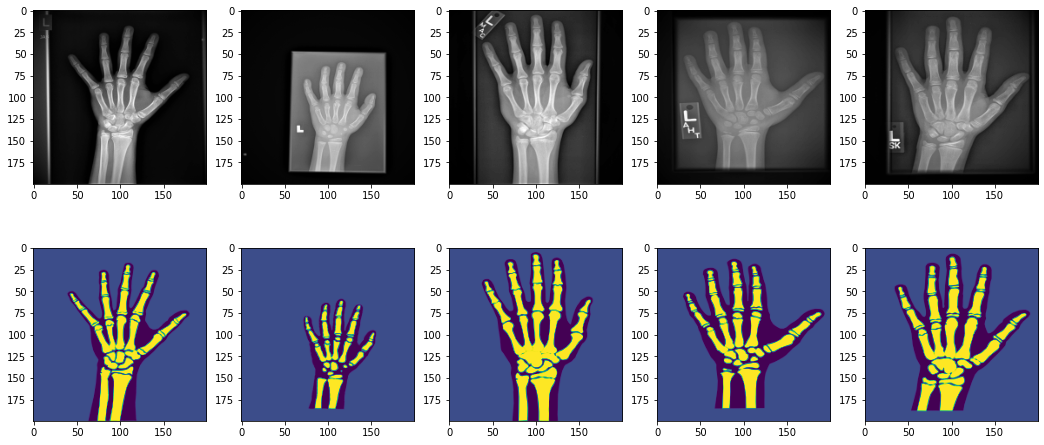

In [ ]:
testing_sample(test_images)

###Predict Test Data

In [ ]:
### running part ini butuh waktu sekitar 1m 22s
training.model.predict(test_images)

In [ ]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1cePD5E-T9mr5W0xPGuzEnUt8Glpvn23U',
                                    dest_path='./model.h5')

In [ ]:
from keras.models import load_model
this_model = load_model("./model.h5")

###Function untuk Prediction

In [ ]:
image_container = []
def prediction_my_images(test_images, total_index):
  for x in range(total_index):
    testing_image = test_images[x]
    testing_image = testing_image.reshape((1,200,200,1))

    prediction = this_model.predict(testing_image)
    prediction = prediction.reshape((200,200,3))
    image_container.append(prediction)

In [ ]:
#prediction_my_images(test_images, *tfd)
#                                 *tfd --> total gambar yang ingin ditampilkan, pilih sesuai keinginan

prediction_my_images(test_images, 5)

###Storing Data to Images

#####remove directory /images

In [ ]:
if os.path.exists('./images') and os.path.isdir('./images'):
  jawaban_hapus_folder = input("ingin menghapus folder images yang telah ada? (y/n)")
  if jawaban_hapus_folder == 'y':
    shutil.rmtree('./images')
else:
  print("tidak ada folder /images, buat terlebih dahulu")

ingin menghapus folder images yang telah ada? (y/n)y


#####make directory /images

In [ ]:
if os.path.exists('./images'):
  print("directory sudah ada")
else:
  os.mkdir('./images')

In [ ]:
# SEBELUM MENGGUNAKAN PERINTAH INI --> Harap cek folder /images
# gunakan perintah pembuatan folder /images
iden_name = 1
for x in image_container:
  matplotlib.image.imsave(f'./images/image-{iden_name}.png', x)
  iden_name = iden_name + 1

###Function untuk Atur plt.subplot

In [ ]:
def set_subplot(num):
  num_cols = math.ceil(num / 3)
  num_rows = math.ceil(num / num_cols)
  return num_cols, num_rows

###Tampilkan Image

len :::  5
2
3


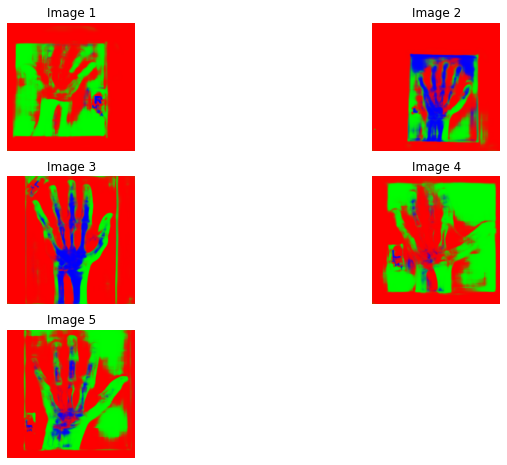

In [ ]:
len_image_container = len(image_container)
print("len ::: ", len_image_container)

cols, rows = set_subplot(len_image_container)
print(cols)
print(rows)

plt.figure(figsize=(12,8))
for i in range(1,len_image_container+1):
    plt.subplot(rows, cols, i)
    plt.imshow(cv2.imread(f'./images/image-{i}.png'))
    plt.axis('off')
    plt.title(f"Image {i}")
    
    